<a href="https://colab.research.google.com/github/bs3537/DS-Unit-2-Linear-Models/blob/master/Bhav_ridge_regression_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [4]:
df.shape

(23040, 21)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [6]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [7]:
df.shape

(23040, 21)

In [8]:
#find null values
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [0]:
#drop apartment number and ease-ment columns

df1 = df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'])

In [10]:
df1.head().T

,0,1,2,3,4
BOROUGH,1,1,1,1,1
NEIGHBORHOOD,CHELSEA,FASHION,FASHION,GREENWICH VILLAGE-WEST,UPPER EAST SIDE (59-79)
BUILDING_CLASS_CATEGORY,13 CONDOS - ELEVATOR APARTMENTS,21 OFFICE BUILDINGS,21 OFFICE BUILDINGS,13 CONDOS - ELEVATOR APARTMENTS,15 CONDOS - 2-10 UNIT RESIDENTIAL
TAX_CLASS_AT_PRESENT,2,4,4,2,2C
BLOCK,716,812,839,592,1379
LOT,1246,68,69,1041,1402
BUILDING_CLASS_AT_PRESENT,R4,O5,O5,R4,R1
ADDRESS,"447 WEST 18TH STREET, PH12A",144 WEST 37TH STREET,40 WEST 38TH STREET,"1 SHERIDAN SQUARE, 8C","20 EAST 65TH STREET, B"
ZIP_CODE,10011,10018,10018,10014,10065
RESIDENTIAL_UNITS,1,0,0,1,1


In [11]:
df1.isnull().sum()

BOROUGH                            0
NEIGHBORHOOD                       0
BUILDING_CLASS_CATEGORY            0
TAX_CLASS_AT_PRESENT               1
BLOCK                              0
LOT                                0
BUILDING_CLASS_AT_PRESENT          1
ADDRESS                            0
ZIP_CODE                           1
RESIDENTIAL_UNITS                  1
COMMERCIAL_UNITS                   1
TOTAL_UNITS                        1
LAND_SQUARE_FEET                  53
GROSS_SQUARE_FEET                  1
YEAR_BUILT                        35
TAX_CLASS_AT_TIME_OF_SALE          0
BUILDING_CLASS_AT_TIME_OF_SALE     0
SALE_PRICE                         0
SALE_DATE                          0
dtype: int64

In [12]:
df1.shape

(23040, 19)

In [0]:
#drop null values
df2 = df1.dropna()

In [14]:
df2.shape

(22953, 19)

In [15]:
df2.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [0]:
#So our dataset is now clean with no null values

Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [17]:
df3 = df2[df2['BUILDING_CLASS_CATEGORY'].str.match('01 ONE FAMILY DWELLINGS')]
df3.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4090,37,A1,1193 SACKET AVENUE,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019
8,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,18,A5,1215 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
9,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,20,A5,1211 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
42,3,MADISON,01 ONE FAMILY DWELLINGS,1,6809,54,A1,2601 AVENUE R,11229.0,1.0,0.0,1.0,"3,333",1262.0,1925.0,1,A1,0,01/01/2019
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


In [0]:
df4 = df3.query('100000 < SALE_PRICE < 2000000')

In [19]:
df4.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [0]:
#So, we have isolated the part of the dataset with BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [21]:
df4.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [22]:
df4.shape

(3151, 19)

In [0]:
import numpy as np
from scipy import stats

In [0]:
#remove outliers for Sales price
df5 = df4[(np.abs(stats.zscore(df4[['SALE_PRICE']])) < 3).all(axis=1)]


In [25]:
df5.shape

(3093, 19)

In [26]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
df_top10 = df5['NEIGHBORHOOD'].value_counts()[:10].index
df_top10


Index(['FLUSHING-NORTH', 'ST. ALBANS', 'SPRINGFIELD GARDENS',
       'SO. JAMAICA-BAISLEY PARK', 'QUEENS VILLAGE', 'GREAT KILLS',
       'SOUTH OZONE PARK', 'BAYSIDE', 'LAURELTON', 'FLUSHING-SOUTH'],
      dtype='object')

In [27]:

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df5.loc[~df5['NEIGHBORHOOD'].isin(df_top10), 'NEIGHBORHOOD'] = 'OTHER'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [28]:
df5.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [29]:
df5.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [30]:
# Sales date needs to be converted to numeric value

df5['SALE_DATE'] = pd.to_datetime(df5["SALE_DATE"]).dt.strftime("%Y%m%d")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
df5.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,20190101
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,20190101
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,20190102
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,20190102
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,20190102


In [33]:
df5['SALE_DATE'] = pd.to_numeric(df5.SALE_DATE.str.replace('-',''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
df5.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                           int64
dtype: object

In [35]:
df5.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,20190101
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,20190101
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,20190102
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,20190102
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,20190102


In [0]:
#The date is now coverted to numeric form

Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:
#isolate train dataset
mask = (df5['SALE_DATE'] > 20190101) & (df5['SALE_DATE'] <= 20190331)

In [0]:
train = df5.loc[mask]


In [39]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,20190102
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,20190102
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,20190102
120,3,OTHER,01 ONE FAMILY DWELLINGS,1,6806,72,A1,1747 EAST 23RD STREET,11229.0,1.0,0.0,1.0,"4,000",1932.0,1930.0,1,A1,1150000,20190102
121,3,OTHER,01 ONE FAMILY DWELLINGS,1,6761,42,A1,1582 EAST 15TH STREET,11230.0,1.0,0.0,1.0,"2,000",1722.0,1920.0,1,A1,836500,20190102


In [40]:
train.shape

(2460, 19)

In [42]:
#isolating test dataset
df5.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,A2,244-15 135 AVENUE,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,20190430
23031,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11612,73,A1,10919 132ND STREET,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,20190430
23032,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11808,50,A0,135-24 122ND STREET,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,20190430
23033,4,SPRINGFIELD GARDENS,01 ONE FAMILY DWELLINGS,1,12295,23,A1,134-34 157TH STREET,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,20190430
23035,4,ST. ALBANS,01 ONE FAMILY DWELLINGS,1,10965,276,A5,111-17 FRANCIS LEWIS BLVD,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,20190430


In [0]:
#The maximum date is till April 30, so we need to isolate data from April 1, 2019 to APRIL 30, 2019 in TEST DATASET
mask2 = (df5['SALE_DATE'] > 20190401) & (df5['SALE_DATE'] <= 20190430)


In [0]:
test = df5.loc[mask2]

In [45]:
test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18500,2,OTHER,01 ONE FAMILY DWELLINGS,1,2555,25,A5,607 OAK TERRACE,10454.0,1.0,0.0,1.0,"2,089",1104.0,2000.0,1,A5,375000,20190402
18521,3,OTHER,01 ONE FAMILY DWELLINGS,1,6293,29,A1,1448 81ST STREET,11228.0,1.0,0.0,1.0,"2,633",1296.0,1930.0,1,A1,900000,20190402
18525,3,OTHER,01 ONE FAMILY DWELLINGS,1,8448,68,A5,2374 EAST 71ST STREET,11234.0,1.0,0.0,1.0,"2,717",1665.0,1970.0,1,A5,780000,20190402
18549,3,OTHER,01 ONE FAMILY DWELLINGS,1,7017,110,A5,2129 MERMAID AVENUE,11224.0,1.0,0.0,1.0,"1,479",1344.0,1993.0,1,A5,580000,20190402
18555,3,OTHER,01 ONE FAMILY DWELLINGS,1,3841,37,S1,427 NEW LOTS AVENUE,11207.0,1.0,1.0,2.0,"2,154",2668.0,1930.0,1,S1,500000,20190402


In [46]:
test.shape

(590, 19)

In [47]:
train.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                           int64
dtype: object

In [0]:
#Many numeric columns in train dataset are still in object form like Borough, tax class, etc. and need to be converted to numeric form

In [49]:
train[["BOROUGH", "TAX_CLASS_AT_PRESENT", "LAND_SQUARE_FEET"]] = train[["BOROUGH", "TAX_CLASS_AT_PRESENT", "LAND_SQUARE_FEET"]].apply(pd.to_numeric, errors='ignore')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [50]:
train.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                           int64
dtype: object

In [0]:
#Let us drop tax class from the dataset

In [0]:
train2 = train.drop(['TAX_CLASS_AT_TIME_OF_SALE'], axis = 1)


In [54]:
train2.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,A1,810000,20190102
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,A1,125000,20190102
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,A5,620000,20190102
120,3,OTHER,01 ONE FAMILY DWELLINGS,1,6806,72,A1,1747 EAST 23RD STREET,11229.0,1.0,0.0,1.0,"4,000",1932.0,1930.0,A1,1150000,20190102
121,3,OTHER,01 ONE FAMILY DWELLINGS,1,6761,42,A1,1582 EAST 15TH STREET,11230.0,1.0,0.0,1.0,"2,000",1722.0,1920.0,A1,836500,20190102


In [0]:
train3 = train2.drop(['BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'ADDRESS', 'SALE_DATE'], axis = 1)

In [56]:
train3.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
78,2,OTHER,4210,19,A1,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,A1,810000
108,3,OTHER,5212,69,A1,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,A1,125000
111,3,OTHER,7930,121,A5,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,A5,620000
120,3,OTHER,6806,72,A1,11229.0,1.0,0.0,1.0,"4,000",1932.0,1930.0,A1,1150000
121,3,OTHER,6761,42,A1,11230.0,1.0,0.0,1.0,"2,000",1722.0,1920.0,A1,836500


In [57]:
train3.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
dtype: object

In [0]:
train3["LAND_SQUARE_FEET"] = train3["LAND_SQUARE_FEET"].str.replace(',','').astype(float)

In [61]:
train3.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                  float64
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
dtype: object

In [0]:
#Let us also do the same exercise with the test dataset

In [62]:
test.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                           int64
dtype: object

In [63]:
test[["BOROUGH", "TAX_CLASS_AT_PRESENT", "LAND_SQUARE_FEET"]] = test[["BOROUGH", "TAX_CLASS_AT_PRESENT", "LAND_SQUARE_FEET"]].apply(pd.to_numeric, errors='ignore')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [64]:
test.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                           int64
dtype: object

In [0]:
#Land sq foot is still in object form, 

In [65]:
#We need to remove commas from land sq foot column to enbale it to convert to numeric form

test["LAND_SQUARE_FEET"] = test["LAND_SQUARE_FEET"].str.replace(',','').astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
test.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                  float64
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                           int64
dtype: object

In [0]:
test2 = test.drop(['BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'ADDRESS', 'SALE_DATE', 'TAX_CLASS_AT_TIME_OF_SALE'], axis = 1)

In [69]:
test2.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
18500,2,OTHER,2555,25,A5,10454.0,1.0,0.0,1.0,2089.0,1104.0,2000.0,A5,375000
18521,3,OTHER,6293,29,A1,11228.0,1.0,0.0,1.0,2633.0,1296.0,1930.0,A1,900000
18525,3,OTHER,8448,68,A5,11234.0,1.0,0.0,1.0,2717.0,1665.0,1970.0,A5,780000
18549,3,OTHER,7017,110,A5,11224.0,1.0,0.0,1.0,1479.0,1344.0,1993.0,A5,580000
18555,3,OTHER,3841,37,S1,11207.0,1.0,1.0,2.0,2154.0,2668.0,1930.0,S1,500000


In [70]:
test2.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                  float64
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
dtype: object

In [0]:
#So, we have our train and test datasets isolated and we may need to do one hot encoding of features like neighborhood, building class etc.

In [0]:
#Let us check the train data column for sales price with no features as the baseline

In [71]:
train3['SALE_PRICE'].mean()

602150.9882113821

In [73]:
from sklearn.metrics import mean_absolute_error

# Arrange y target vectors
target = 'SALE_PRICE'
y_train = train3[target]
y_test = test2[target]

# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (sale price): {mae:.2f} USD')

# Test Error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (sale price): {mae:.2f} USD')

Mean Baseline (using 0 features)
Train Error (sale price): 194994.90 USD
Test Error (sale price): 187755.33 USD


In [0]:
#Building multiple regression model

In [0]:
#Apply one hot encoding on train and test datasets
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
hot_train = encoder.fit_transform(train3)
hot_test = encoder.transform(test2)

In [79]:
print(hot_train.shape)
hot_train.head()
#The output shows new columns added representing neighborhood and building class at sale after one hot encoding.

(2460, 44)


,BOROUGH,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_ST. ALBANS,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,SALE_PRICE
78,2,1,0,0,0,0,0,0,0,0,0,0,4210,19,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3500.0,2043.0,1925.0,1,0,0,0,0,0,0,0,0,0,810000
108,3,1,0,0,0,0,0,0,0,0,0,0,5212,69,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,4000.0,2680.0,1899.0,1,0,0,0,0,0,0,0,0,0,125000
111,3,1,0,0,0,0,0,0,0,0,0,0,7930,121,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1710.0,1872.0,1940.0,0,1,0,0,0,0,0,0,0,0,620000
120,3,1,0,0,0,0,0,0,0,0,0,0,6806,72,1,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,4000.0,1932.0,1930.0,1,0,0,0,0,0,0,0,0,0,1150000
121,3,1,0,0,0,0,0,0,0,0,0,0,6761,42,1,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,2000.0,1722.0,1920.0,1,0,0,0,0,0,0,0,0,0,836500


In [80]:
print(hot_test.shape)
hot_test.head()

(590, 44)


,BOROUGH,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_ST. ALBANS,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,SALE_PRICE
18500,2,1,0,0,0,0,0,0,0,0,0,0,2555,25,0,1,0,0,0,0,0,0,0,0,0,0,10454.0,1.0,0.0,1.0,2089.0,1104.0,2000.0,0,1,0,0,0,0,0,0,0,0,375000
18521,3,1,0,0,0,0,0,0,0,0,0,0,6293,29,1,0,0,0,0,0,0,0,0,0,0,0,11228.0,1.0,0.0,1.0,2633.0,1296.0,1930.0,1,0,0,0,0,0,0,0,0,0,900000
18525,3,1,0,0,0,0,0,0,0,0,0,0,8448,68,0,1,0,0,0,0,0,0,0,0,0,0,11234.0,1.0,0.0,1.0,2717.0,1665.0,1970.0,0,1,0,0,0,0,0,0,0,0,780000
18549,3,1,0,0,0,0,0,0,0,0,0,0,7017,110,0,1,0,0,0,0,0,0,0,0,0,0,11224.0,1.0,0.0,1.0,1479.0,1344.0,1993.0,0,1,0,0,0,0,0,0,0,0,580000
18555,3,1,0,0,0,0,0,0,0,0,0,0,3841,37,0,0,0,0,0,0,1,0,0,0,0,0,11207.0,1.0,1.0,2.0,2154.0,2668.0,1930.0,0,0,0,0,0,0,1,0,0,0,500000


In [0]:
#Building multiple regression model after hot encoding categorical features

In [0]:
target = 'SALE_PRICE'

features = hot_train.columns.drop([target])

X_train = hot_train[features]
y_train = hot_train[target]
X_test = hot_test[features]
y_test = hot_test[target]

In [84]:
print(X_train.shape)
X_train.head()

(2460, 43)


,BOROUGH,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_ST. ALBANS,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8
78,2,1,0,0,0,0,0,0,0,0,0,0,4210,19,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3500.0,2043.0,1925.0,1,0,0,0,0,0,0,0,0,0
108,3,1,0,0,0,0,0,0,0,0,0,0,5212,69,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,4000.0,2680.0,1899.0,1,0,0,0,0,0,0,0,0,0
111,3,1,0,0,0,0,0,0,0,0,0,0,7930,121,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1710.0,1872.0,1940.0,0,1,0,0,0,0,0,0,0,0
120,3,1,0,0,0,0,0,0,0,0,0,0,6806,72,1,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,4000.0,1932.0,1930.0,1,0,0,0,0,0,0,0,0,0
121,3,1,0,0,0,0,0,0,0,0,0,0,6761,42,1,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,2000.0,1722.0,1920.0,1,0,0,0,0,0,0,0,0,0


In [85]:
print(X_test.shape)
X_test.head()

(590, 43)


,BOROUGH,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_ST. ALBANS,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8
18500,2,1,0,0,0,0,0,0,0,0,0,0,2555,25,0,1,0,0,0,0,0,0,0,0,0,0,10454.0,1.0,0.0,1.0,2089.0,1104.0,2000.0,0,1,0,0,0,0,0,0,0,0
18521,3,1,0,0,0,0,0,0,0,0,0,0,6293,29,1,0,0,0,0,0,0,0,0,0,0,0,11228.0,1.0,0.0,1.0,2633.0,1296.0,1930.0,1,0,0,0,0,0,0,0,0,0
18525,3,1,0,0,0,0,0,0,0,0,0,0,8448,68,0,1,0,0,0,0,0,0,0,0,0,0,11234.0,1.0,0.0,1.0,2717.0,1665.0,1970.0,0,1,0,0,0,0,0,0,0,0
18549,3,1,0,0,0,0,0,0,0,0,0,0,7017,110,0,1,0,0,0,0,0,0,0,0,0,0,11224.0,1.0,0.0,1.0,1479.0,1344.0,1993.0,0,1,0,0,0,0,0,0,0,0
18555,3,1,0,0,0,0,0,0,0,0,0,0,3841,37,0,0,0,0,0,0,1,0,0,0,0,0,11207.0,1.0,1.0,2.0,2154.0,2668.0,1930.0,0,0,0,0,0,0,1,0,0,0


In [0]:
#Do feature selection with SelectKBest.

In [86]:
#number of features in X train dataset
features = X_train.columns
n = len(features)
n

43

In [87]:
# Select the 15 features that best correlate with the target Sale price

from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

(2460, 15)

In [88]:
#Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
NEIGHBORHOOD_BAYSIDE
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK
NEIGHBORHOOD_SPRINGFIELD GARDENS
NEIGHBORHOOD_FLUSHING-SOUTH
NEIGHBORHOOD_ST. ALBANS
BLOCK
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_A6
ZIP_CODE
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_A6

Features Not Selected:
BOROUGH
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_LAURELTON
NEIGHBORHOOD_GREAT KILLS
NEIGHBORHOOD_SOUTH OZONE PARK
NEIGHBORHOOD_QUEENS VILLAGE
LOT
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME

In [96]:
# How many features should be selected?
#MAE with different number of features in the linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features:
Test MAE: $168,652 

2 features:
Test MAE: $164,672 

3 features:
Test MAE: $163,000 

4 features:
Test MAE: $158,623 

5 features:
Test MAE: $158,230 

6 features:
Test MAE: $158,230 

7 features:
Test MAE: $142,836 

8 features:
Test MAE: $141,192 

9 features:
Test MAE: $140,937 

10 features:
Test MAE: $140,937 

11 features:
Test MAE: $139,670 

12 features:
Test MAE: $142,008 

13 features:
Test MAE: $142,148 

14 features:
Test MAE: $141,586 

15 features:
Test MAE: $142,015 

16 features:
Test MAE: $142,157 

17 features:
Test MAE: $142,203 

18 features:
Test MAE: $142,203 

19 features:
Test MAE: $142,203 

20 features:
Test MAE: $142,217 

21 features:
Test MAE: $142,219 

22 features:
Test MAE: $142,219 

23 features:
Test MAE: $142,226 

24 features:
Test MAE: $141,712 

25 features:
Test MAE: $141,310 

26 features:
Test MAE: $141,310 

27 features:
Test MAE: $141,310 

28 features:
Test MAE: $141,310 

29 features:
Test MAE: $141,171 

30 features:
Test MAE: 

In [0]:
#Fit a ridge regression model with multiple features.

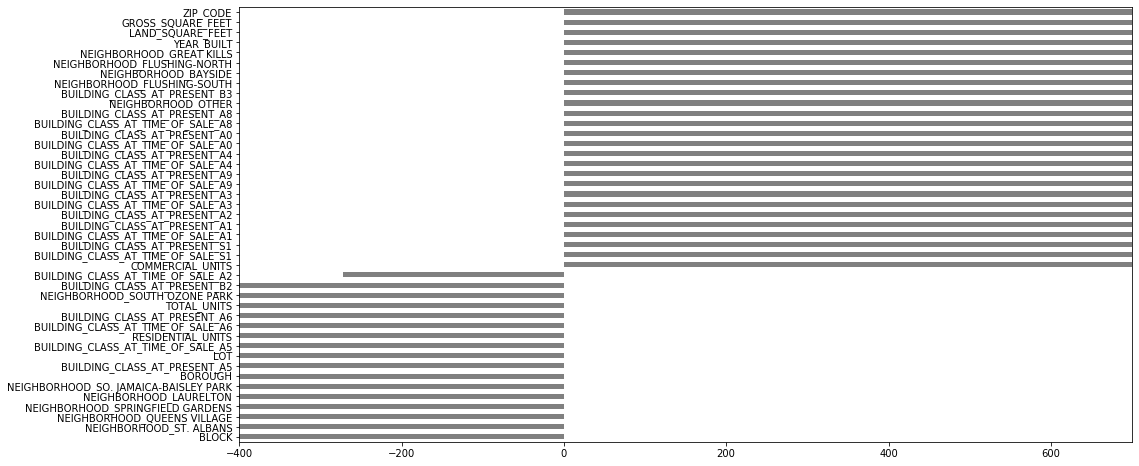

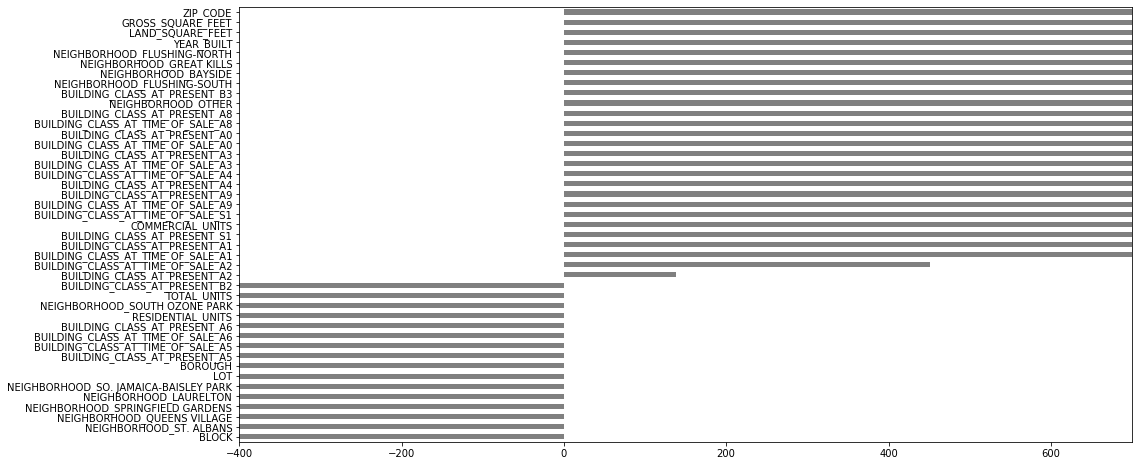

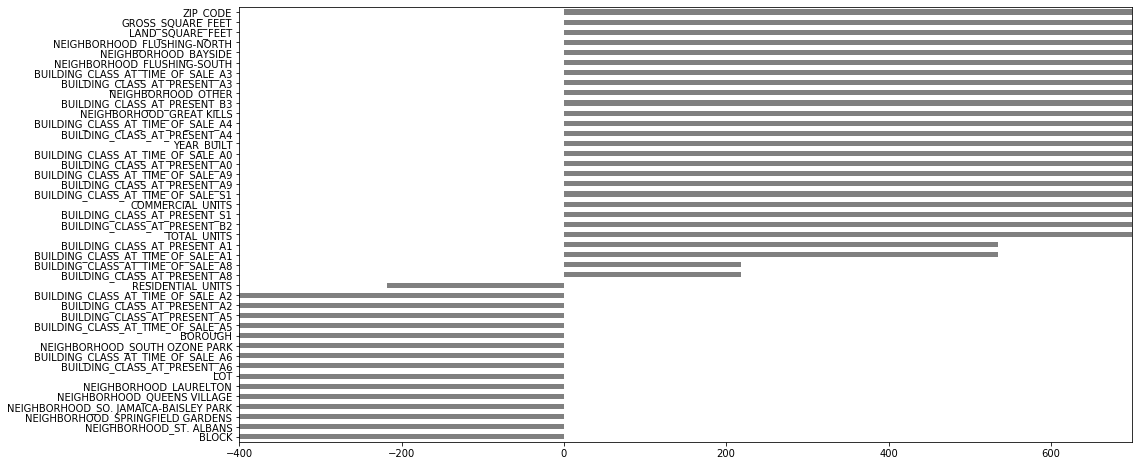

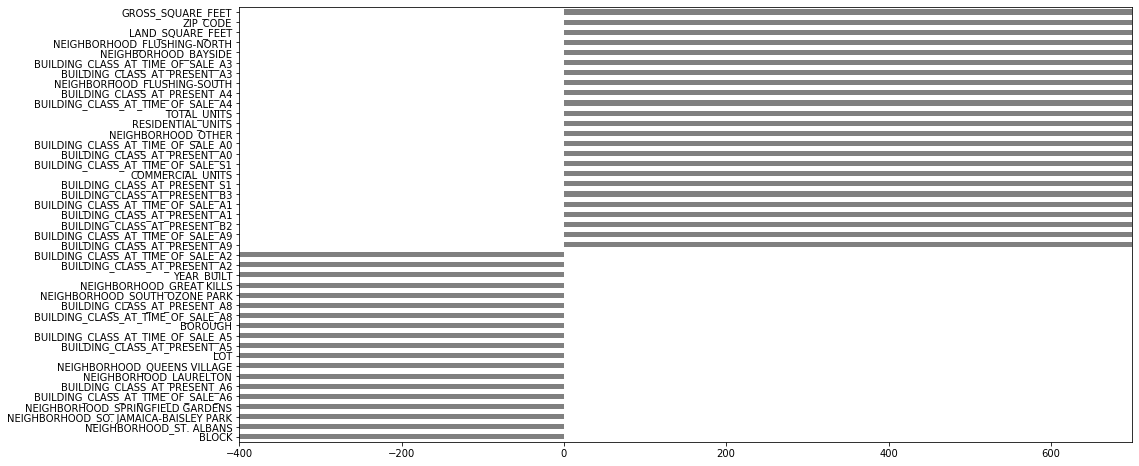

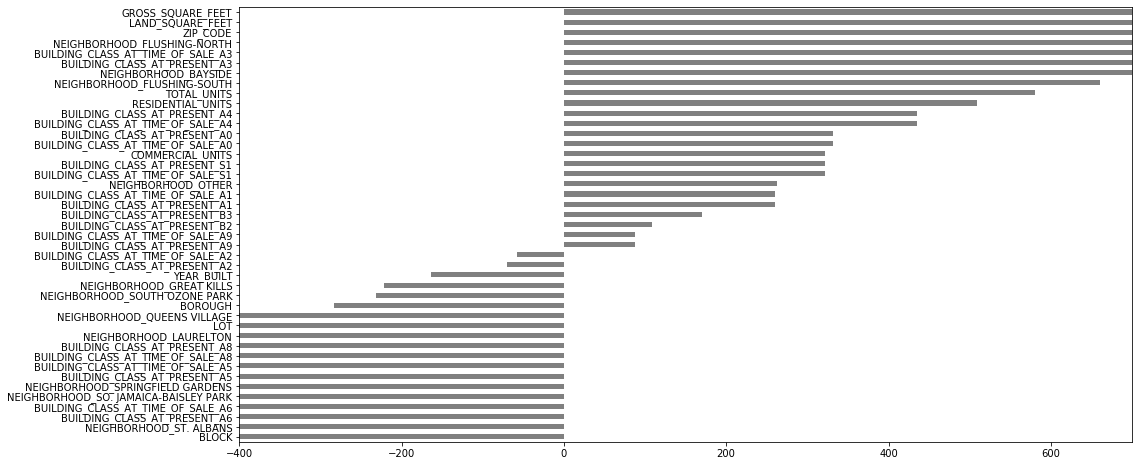

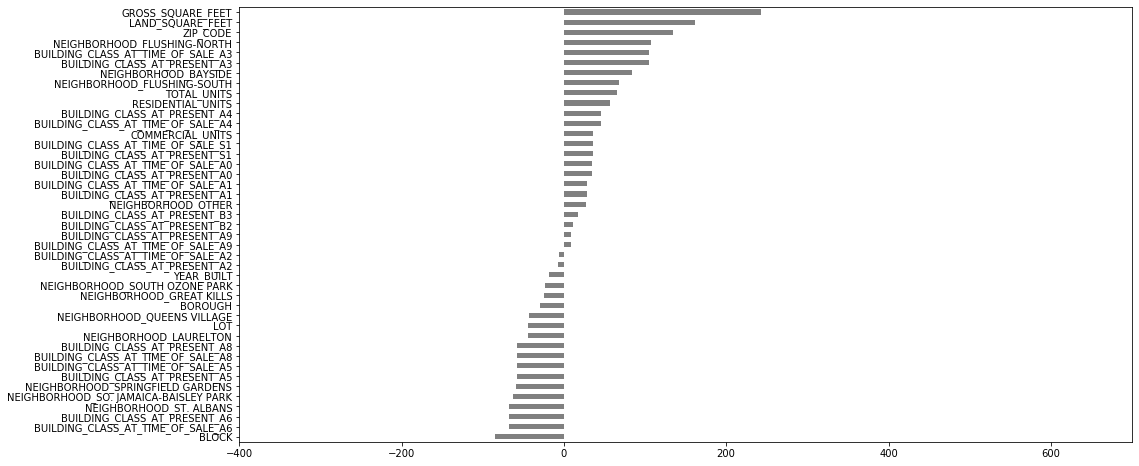

In [97]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()

In [98]:
from sklearn.metrics import mean_squared_error

alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test_scaled))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

0 40049336483.13622
1 38405089961.412285
2 38400864003.38084
3 38396726512.43237
4 38392670110.23928
5 38388689901.37846
6 38384782429.01406
7 38380945118.07181
8 38377175959.55797
9 38373473322.36917
10 38369835836.2961
11 38366262316.6494
12 38362751714.18789
13 38359303080.95441
14 38355915546.41081
15 38352588300.415016
16 38349320580.848946
17 38346111664.47289
18 38342960860.05995
19 38339867503.1686
20 38336830952.11021
21 38333850584.800224
22 38330925796.27128
23 38328055996.68793
24 38325240609.74558
25 38322479071.36675
26 38319770828.629486
27 38317115338.87883
28 38314512068.98345
29 38311960494.70882
30 38309460100.18402
31 38307010377.4449
32 38304610826.03935
33 38302260952.68395
34 38299960270.962845
35 38297708301.062065
36 38295504569.5332
37 38293348609.082085
38 38291239958.37835
39 38289178161.88292
40 38287162769.69076
41 38285193337.386734
42 38283269425.91271
43 38281390601.444534
44 38279556435.277466
45 38277766503.719124
46 38276020387.98889
47 38274317674.1

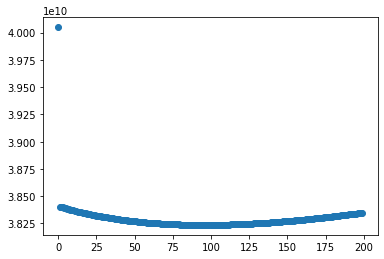

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);

The alpha parameter corresponds to the weight being given to the extra penalty being calculated by Tikhonov regularization (this parameter is sometimes referred to as $\lambda$ in the context of ridge regression).

Normal linear regression (OLS) minimizes the sum of square error of the residuals.

Ridge regression minimizes the sum of square error of the residuals AND the squared slope of the fit model, times the alpha parameter.

This is why the MSE for the first model in the for loop (alpha=0) is the same as the MSE for linear regression - it's the same model!

As alpha is increased, we give more and more penalty to a steep slope. In two or three dimensions this is fairly easy to visualize - beyond, think of it as penalizing coefficient size. Each coefficient represents the slope of an individual dimension (feature) of the model, so ridge regression is just squaring and summing those.

So while alpha=0 reduces to OLS, as alpha approaches infinity eventually the penalty gets so extreme that the model will always output every coefficient as 0 (any non-zero coefficient resulting in a penalty that outweighs whatever improvement in the residuals), and just fit a flat model with intercept at the mean of the dependent variable.

Of course, what we want is somewhere in-between these extremes. Intuitively, what we want to do is apply an appropriate "cost" or penalty to the model for fitting parameters, much like adjusted $R^2$ takes into account the cost of adding complexity to a model. What exactly is an appropriate penalty will vary, so you'll have to put on your model comparison hat and give it a go!

PS - scaling the data helps, as that way this cost is consistent and can be added uniformly across features, and it is simpler to search for the alpha parameter.

The regularization used by Ridge Regression is also known as $L^2$ regularization</strong>, due to the squaring of the slopes being summed. This corresponds to $L^2$ space, a metric space of square-integrable functions that generally measure what we intuitively think of as "distance" (at least, on a plane) - what is referred to as Euclidean distance.

The other famous norm is $L^1$, also known as taxicab geometry, because it follows the "grid" to measure distance like a car driving around city blocks (rather than going directly like $L^2$). When referred to as a distance this is called "Manhattan distance", and can be used for regularization

All this comes down to - regularization means increasing model bias by "watering down" coefficients with a penalty typically based on some sort of distance metric, and thus reducing variance (overfitting the model to the noise in the data). It gives us another lever to try and another tool for our toolchest!